In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gggenes)
library(Biostrings)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching 

In [2]:
## Adjust PATH
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR"

In [3]:
## Functions

#' Get list entry and use NA for missing information
#'
#' Get entries from list entries and ignore missing information (e.g. NULL)
#' as well as errors (e.g. missing columns in data.frame)
#' 
get_list_entry <- function(x) {

    x <- tryCatch(
        error = function(cnd) NA, x
    )

    if (is.null(x)) {x <- NA}

    return(x)
}

In [13]:
# Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'

## Data storage
path <- "data/ncbi_phage-genomes/"
overview <- paste0(path, 'overview.csv')

## File structure
collections <- c('all_genomes', 'core_genomes')
fs <- list()
for (i in collections) {
    fs[[i]]$path <- paste0(path, i, '/')
    fs[[i]]$accession <- paste0(path, i, '_accession.txt')
    fs[[i]]$archive <- paste0(fs[[i]]$path, 'ncbi_dataset/', 'data/')
    for (ii in list.files(fs[[i]]$archive)) {
        key <- str_split(ii, '\\.')[[1]][[1]]
        fs[[i]][[key]] <- paste0(fs[[i]]$archive, ii)
    }
}
fs
all(file.exists(unlist(fs)))
which(!file.exists(unlist(fs)))

$all_genomes
$all_genomes$path
[1] "data/ncbi_phage-genomes/all_genomes/"

$all_genomes$accession
[1] "data/ncbi_phage-genomes/all_genomes_accession.txt"

$all_genomes$archive
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/"

$all_genomes$annotation_report
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/annotation_report.jsonl"

$all_genomes$annotation
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/annotation.gtf"

$all_genomes$biosample_report
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/biosample_report.jsonl"

$all_genomes$cds
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/cds.fna"

$all_genomes$data_report
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/data_report.jsonl"

$all_genomes$dataset_catalog
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/dataset_catalog.json"

$all_genomes$genomic
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/genomic.fna"

$all_genomes$metadata
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/metadata.tsv"

$all_genomes$protein
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/protein.faa"

$all_genomes$virus_dataset
[1] "data/ncbi_phage-genomes/all_genomes/ncbi_dataset/data/virus_dataset.md"


$core_genomes
$core_genomes$path
[1] "data/ncbi_phage-genomes/core_genomes/"

$core_genomes$accession
[1] "data/ncbi_phage-genomes/core_genomes_accession.txt"

$core_genomes$archive
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/"

$core_genomes$annotation_report
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/annotation_report.jsonl"

$core_genomes$annotation
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/annotation.gtf"

$core_genomes$biosample_report
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/biosample_report.jsonl"

$core_genomes$cds
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/cds.fna"

$core_genomes$data_report
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/data_report.jsonl"

$core_genomes$dataset_catalog
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/dataset_catalog.json"

$core_genomes$genomic
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/genomic.fna"

$core_genomes$metadata
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/metadata.tsv"

$core_genomes$protein
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/protein.faa"

$core_genomes$virus_dataset
[1] "data/ncbi_phage-genomes/core_genomes/ncbi_dataset/data/virus_dataset.md"

[1] TRUE

integer(0)

In [38]:
# Read data

## Select components
components <- c('accession', 'metadata')

## Read from file structure
ds <- list()
for (i in names(fs)) {
    ds[[i]] <- list()
    for (ii in components) {
        suffix <- str_split(fs[[i]][[ii]], '\\.')[[1]][[2]]
        if (suffix == 'txt') {ds[[i]][[ii]] <- readLines(fs[[i]][[ii]])}
        if (suffix == 'gtf') {ds[[i]][[ii]] <- read.delim(fs[[i]][[ii]])}
        if (suffix == 'tsv') {ds[[i]][[ii]] <- read.delim(fs[[i]][[ii]])}
    }
}

## Add single components
ds$core_genomes$annotation <- read.delim(fs$core_genomes$annotation)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


In [11]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

[1] "Reading table phages"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


In [19]:
# Check data completeness

## Downloaded genomes
message('Genome source database')
table(ds$core_genomes$metadata$Source.database)
table(ds$all_genomes$metadata$Source.database)

## Matching accession numbers
message('Genomes downloaded as specified in file')
table(ds$core_genomes$accession %in% ds$core_genomes$metadata$Accession)
table(ds$all_genomes$accession %in% ds$all_genomes$metadata$Accession)

message('Overlap between collections')
length(intersect(ds$all_genomes$metadata$Accession, ds$core_genomes$metadata$Accession))

## Overlap with table S7
message('Overlap to table phages')
data <- tables$phages
table(data$accession %in% ds$core_genomes$accession)
table(data$accession %in% ds$all_genomes$accession)

Genome source database




GenBank  RefSeq 
     18      17 


GenBank  RefSeq 
  11705    2626 

Genomes downloaded as specified in file




TRUE 
  35 


FALSE  TRUE 
25271 14331 

Overlap between collections



[1] 11

Overlap to table phages




TRUE 
  35 


TRUE 
  35 

In [27]:
# Create summary report
report <- rbind(
    ds$core_genomes$metadata,
    ds$all_genomes$metadata
) %>% unique()

## Indicate presence in collection
report$in_selection <- report$Accession %in% ds$core_genomes$metadata$Accession
report$in_all_genomes <- report$Accession %in% ds$all_genomes$metadata$Accession

## View
rbind(head(report,3),tail(report,3))

,Accession,BioProjects,BioSample.accession,Completeness,Gene.count,Geographic.Location,Geographic.Region,Geographic.State,Host.Common.Name,Host.Infraspecific.Names.Breed,⋯,Virus.Infraspecific.Names.Cultivar,Virus.Infraspecific.Names.Ecotype,Virus.Infraspecific.Names.Isolate,Virus.Infraspecific.Names.Sex,Virus.Infraspecific.Names.Strain,Virus.Name,Virus.Pangolin.Classification,Virus.Taxonomic.ID,in_selection,in_all_genomes
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<int>,<lgl>,<lgl>
1,AF158101.6,,,COMPLETE,278,,,,NA,NA,⋯,NA,NA,NA,NA,NA,Escherichia phage T4,NA,2681598,TRUE,FALSE
2,MK639187.1,,,COMPLETE,266,China,Asia,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage SSE1,NA,2562131,TRUE,FALSE
3,MK962754.1,,,COMPLETE,280,Ireland,Europe,,NA,NA,⋯,NA,NA,NA,NA,NA,Shigella phage JK36,NA,2591060,TRUE,FALSE
14364,ON995367.1,,,COMPLETE,49,Sri Lanka,Asia,,NA,NA,⋯,NA,NA,NA,NA,NA,Pectobacterium phage vB_PcaP_P15_PC2B6,NA,2968434,FALSE,TRUE
14365,ON996339.1,,,COMPLETE,54,China,Asia,,NA,NA,⋯,NA,NA,NA,NA,NA,Salmonella phage T102,NA,2968433,FALSE,TRUE
14366,ON996340.1,,,COMPLETE,68,Bulgaria,Europe,,NA,NA,⋯,NA,NA,NA,NA,NA,,NA,NA,FALSE,TRUE


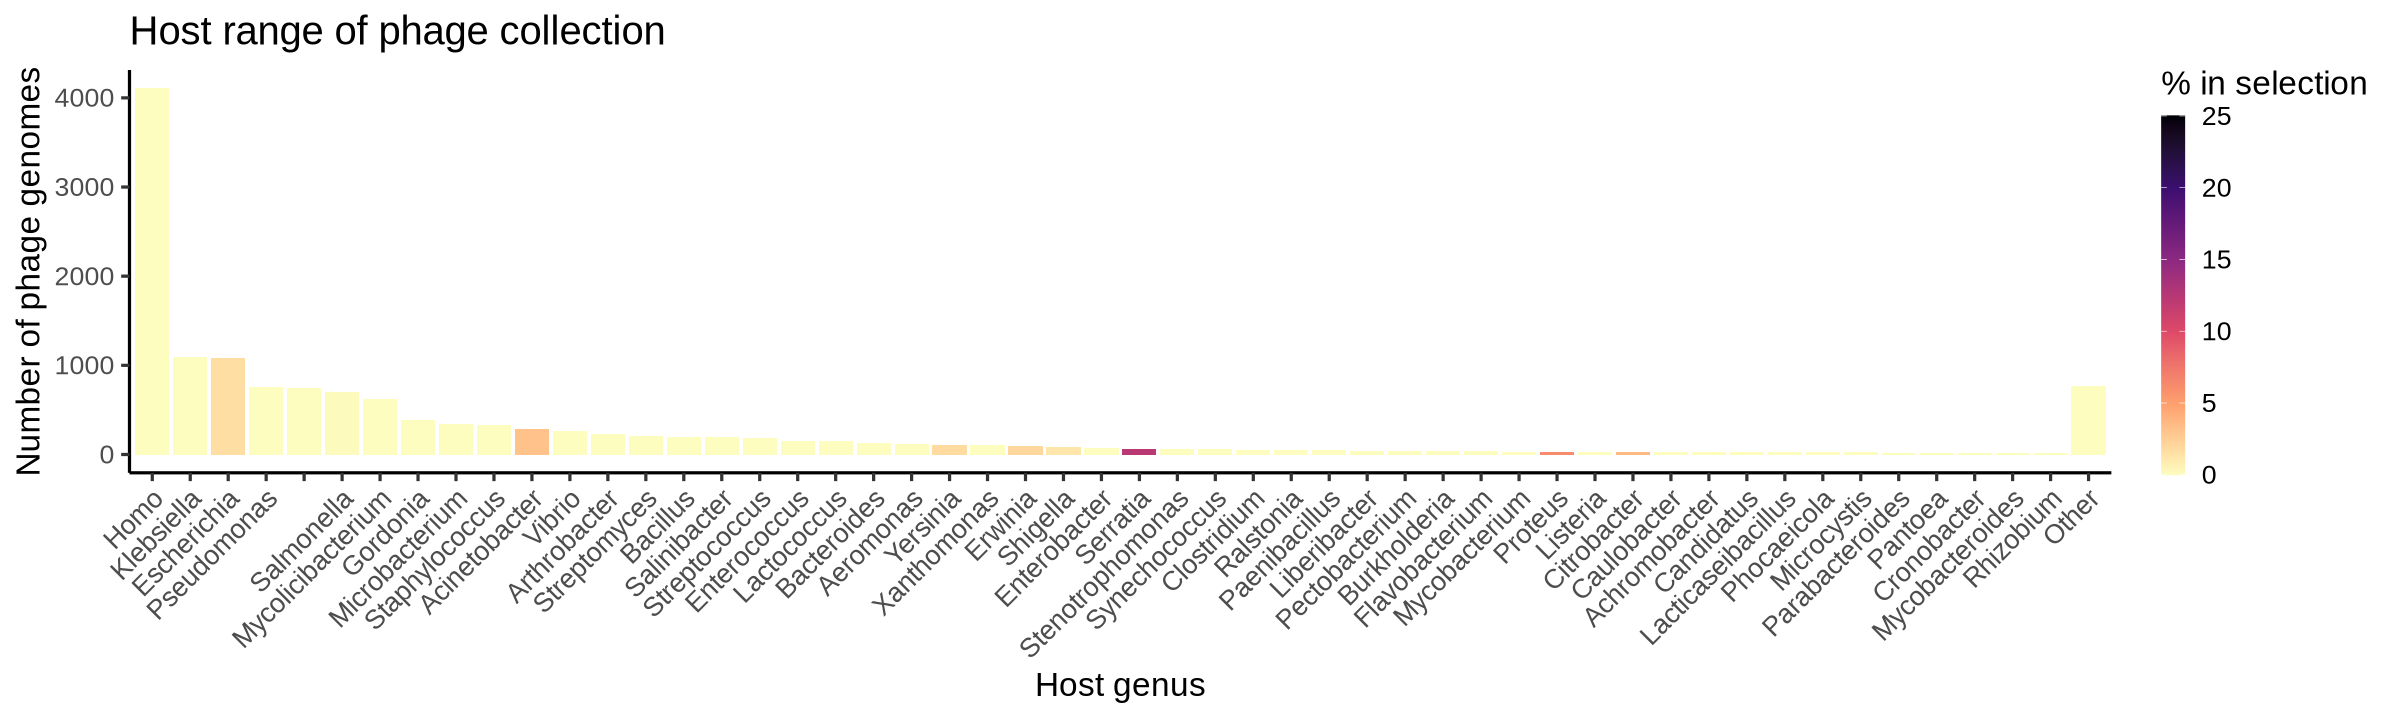

In [30]:
# Host range
options(repr.plot.width=20, repr.plot.height=6)

## Fetch data
df <- data.frame(host = report$Host.Name, in_selection=report$in_selection, N=1)
df$genus <- str_split(df$host, ' ', simplify=TRUE)[,1]

## Summarize
df <- df %>% group_by(genus) %>% summarise(total = sum(N), in_selection=sum(in_selection)/total*100)
df$genus[df$total < 20] <- 'Other'


## Order
df <- df[order(df$total, decreasing = TRUE), ]
df$genus <- factor(df$genus, unique(df$genus))

## Plot
ggplot(df, aes(genus, total, fill=in_selection)) +
  geom_col() +
  scale_fill_viridis_c(option='A', direction = -1) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  guides(
      fill = guide_colorbar(barheight=15, barwidth=1, )
  ) +
  labs(title='Host range of phage collection', x = 'Host genus', y='Number of phage genomes', fill='% in selection')

In [39]:
# Search gene names
data <- ds$core_genomes$annotation
#data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')]
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')]

[1] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [3] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [5] "putative thymidylate synthase" "dTMP (thymidylate) synthase"  
 [7] "putative thymidylate synthase" "putative thymidylate synthase"
 [9] "putative thymidylate synthase" "putative thymidylate synthase"
[11] "thymidylate synthase"          "thymidylate synthase"         
[13] "putative thymidylate synthase" "thymidylate synthase"         
[15] "thymidylate synthase"          "thymidylate synthase"         
[17] "thymidylate synthase"          "thymidylate synthase"         
[19] "thymidylate synthase"          "thymidylate synthase"         
[21] "thymidylate synthase"          "thymidylate synthase"         
[23] "thymidylate synthase"          "thymidylate synthase"         
[25] "thymidylate synthase"          "thymidylate synthase"         
[27] "thymidylate synthase"          "thymidylate synthase"         
[29] "thymidylate synthase"          "thymidylate synthase"         
[31] "thymidylate synthase"          "thymidylate synthase"         
[33] "putative thymidylate synthase" "thymidylate synthase"         
[35] "thymidylate synthase"          "thymidylate synthase"         
[37] "Putative thymidylate synthase" "thymidylate synthase"         
[39] "thymidylate synthase"          "thymidylate synthase"         
[41] "thymidylate synthase"          "thymidylate synthase"         
[43] "thymidylate synthase"          "thymidylate synthase"         
[45] "thymidylate synthase"          "putative thymidylate synthase"
[47] "thymidylate synthase"          "thymidylate synthase"         
[49] "thymidylate synthase"          "thymidylate synthase"         
[51] "thymidylate synthase"

In [40]:
# Annotation

# Transfer into new vector
data$ann_level_1 <- data$Gene.CDS.Name
data$ann_level_1 <- 'Other'

## Hypothetical
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'hypothetical')] <- 'Hypothetical'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'Hypothetical')] <- 'Hypothetical'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'hypothetical')] <- 'Hypothetical'

## Structural
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'head')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'tail')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'sheath')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'base')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'capsid')] <- 'Structural'

## Essential genes
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'endonuclease')] <- 'Endonuclease'

## Step A - dCTP modification
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'HMase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'HMase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'DNA pol')] <- 'DNA pol'

## Step B - UTP arabinosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Isomerase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Isomerase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Ara transfer'
# Most Aat genes are not annotated !!!

## Step E - function?
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

## Modification machinery
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'TS'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'TK'

unique(data$ann_level_1)

[1] "Other"        "dCTPase"      "Glu transfer" "HMase"        "DNA pol"     
 [6] "dNMP kinase"  "Thy syn"      "Isomerase"    "Thy kin"      "Ara transfer"
[11] "NTP transfer"

In [41]:
# Add colors
cols <- list()

cols$ann_level_1 <- c(
    'Other' = 'grey90',
    'TS' = 'indianred',
    'HMase' = 'darkorange',
    'Aat' = 'green',
    'DNA pol' = 'navy',
    'Ara isom.' = 'purple',
    'PH isom.' = 'skyblue',
    'NTP transf.' = 'hotpink',
    'Peptidase' = 'pink',
    'TK' = 'yellow',
    'GT' = 'cyan3'
)

cols$ann_level_1 <- c(
    'Other' = 'grey90',
    'dCTPase' = 'palegreen',
    'HMase' = 'plum',
    'dNMP kinase' = 'seagreen',
    'DNA pol' = 'darkolivegreen',
    'Isomerase' = 'navy',
    'NTP transfer' = 'cyan3',
    'Glu transfer' = 'darkorange',
    'Ara transfer' = 'indianred',
    'Thy syn' = 'purple',
    'Thy kin' = 'hotpink'
)
data$ann_level_1 <- factor(data$ann_level_1, names(cols$ann_level_1))

In [85]:
# Modify data
names(data)

## Modification group
index <- match(data$Accession, tables$phages$accession)
data$aat <- tables$phages$group_aat[index]
data$modification <- tables$phages$group_modification[index]

## Genome size
data <- data %>% group_by(Accession) %>% mutate(
    genomeSize = max(Gene.CDS.Nucleotide.FASTA.Range.Stop, na.rm=TRUE) - min(Gene.CDS.Nucleotide.FASTA.Range.Start, na.rm=TRUE)
)

[1] "Accession"                                                 
 [2] "Gene.CDS.Accession"                                        
 [3] "Gene.CDS.CDD.Accession"                                    
 [4] "Gene.CDS.CDD.Name"                                         
 [5] "Gene.CDS.CDD.Range.Order"                                  
 [6] "Gene.CDS.CDD.Range.Orientation"                            
 [7] "Gene.CDS.CDD.Range.Start"                                  
 [8] "Gene.CDS.CDD.Range.Stop"                                   
 [9] "Gene.CDS.Mature.Peptide.Accession"                         
[10] "Gene.CDS.Mature.Peptide.CDD.Accession"                     
[11] "Gene.CDS.Mature.Peptide.CDD.Name"                          
[12] "Gene.CDS.Mature.Peptide.CDD.Range.Order"                   
[13] "Gene.CDS.Mature.Peptide.CDD.Range.Orientation"             
[14] "Gene.CDS.Mature.Peptide.CDD.Range.Start"                   
[15] "Gene.CDS.Mature.Peptide.CDD.Range.Stop"                    
[16] "Gene.CDS.Mature.Peptide.Name"                              
[17] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Accession"        
[18] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Hash"             
[19] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Range.Order"      
[20] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Range.Orientation"
[21] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Range.Start"      
[22] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Range.Stop"       
[23] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Sequence.ID"      
[24] "Gene.CDS.Mature.Peptide.Nucleotide.FASTA.Title"            
[25] "Gene.CDS.Mature.Peptide.Other.Names"                       
[26] "Gene.CDS.Mature.Peptide.PDB.IDs"                           
[27] "Gene.CDS.Mature.Peptide.Protein.Completeness"              
[28] "Gene.CDS.Mature.Peptide.Protein.FASTA.Accession"           
[29] "Gene.CDS.Mature.Peptide.Protein.FASTA.Hash"                
[30] "Gene.CDS.Mature.Peptide.Protein.FASTA.Range.Order"         
[31] "Gene.CDS.Mature.Peptide.Protein.FASTA.Range.Orientation"   
[32] "Gene.CDS.Mature.Peptide.Protein.FASTA.Range.Start"         
[33] "Gene.CDS.Mature.Peptide.Protein.FASTA.Range.Stop"          
[34] "Gene.CDS.Mature.Peptide.Protein.FASTA.Sequence.ID"         
[35] "Gene.CDS.Mature.Peptide.Protein.FASTA.Title"               
[36] "Gene.CDS.Mature.Peptide.UniProtID"                         
[37] "Gene.CDS.Mature.Peptide.UniProtName"                       
[38] "Gene.CDS.Name"                                             
[39] "Gene.CDS.Nucleotide.FASTA.Accession"                       
[40] "Gene.CDS.Nucleotide.FASTA.Hash"                            
[41] "Gene.CDS.Nucleotide.FASTA.Range.Order"                     
[42] "Gene.CDS.Nucleotide.FASTA.Range.Orientation"               
[43] "Gene.CDS.Nucleotide.FASTA.Range.Start"                     
[44] "Gene.CDS.Nucleotide.FASTA.Range.Stop"                      
[45] "Gene.CDS.Nucleotide.FASTA.Sequence.ID"                     
[46] "Gene.CDS.Nucleotide.FASTA.Title"                           
[47] "Gene.CDS.Other.Names"                                      
[48] "Gene.CDS.PDB.IDs"                                          
[49] "Gene.CDS.Protein.Completeness"                             
[50] "Gene.CDS.Protein.FASTA.Accession"                          
[51] "Gene.CDS.Protein.FASTA.Hash"                               
[52] "Gene.CDS.Protein.FASTA.Range.Order"                        
[53] "Gene.CDS.Protein.FASTA.Range.Orientation"                  
[54] "Gene.CDS.Protein.FASTA.Range.Start"                        
[55] "Gene.CDS.Protein.FASTA.Range.Stop"                         
[56] "Gene.CDS.Protein.FASTA.Sequence.ID"                        
[57] "Gene.CDS.Protein.FASTA.Title"                              
[58] "Gene.CDS.UniProtID"                                        
[59] "Gene.CDS.UniProtName"                                      
[60] "Gene.NCBI.GeneID"                                          
[61] "Gene.Genomic.Accession"            

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_text()`).”


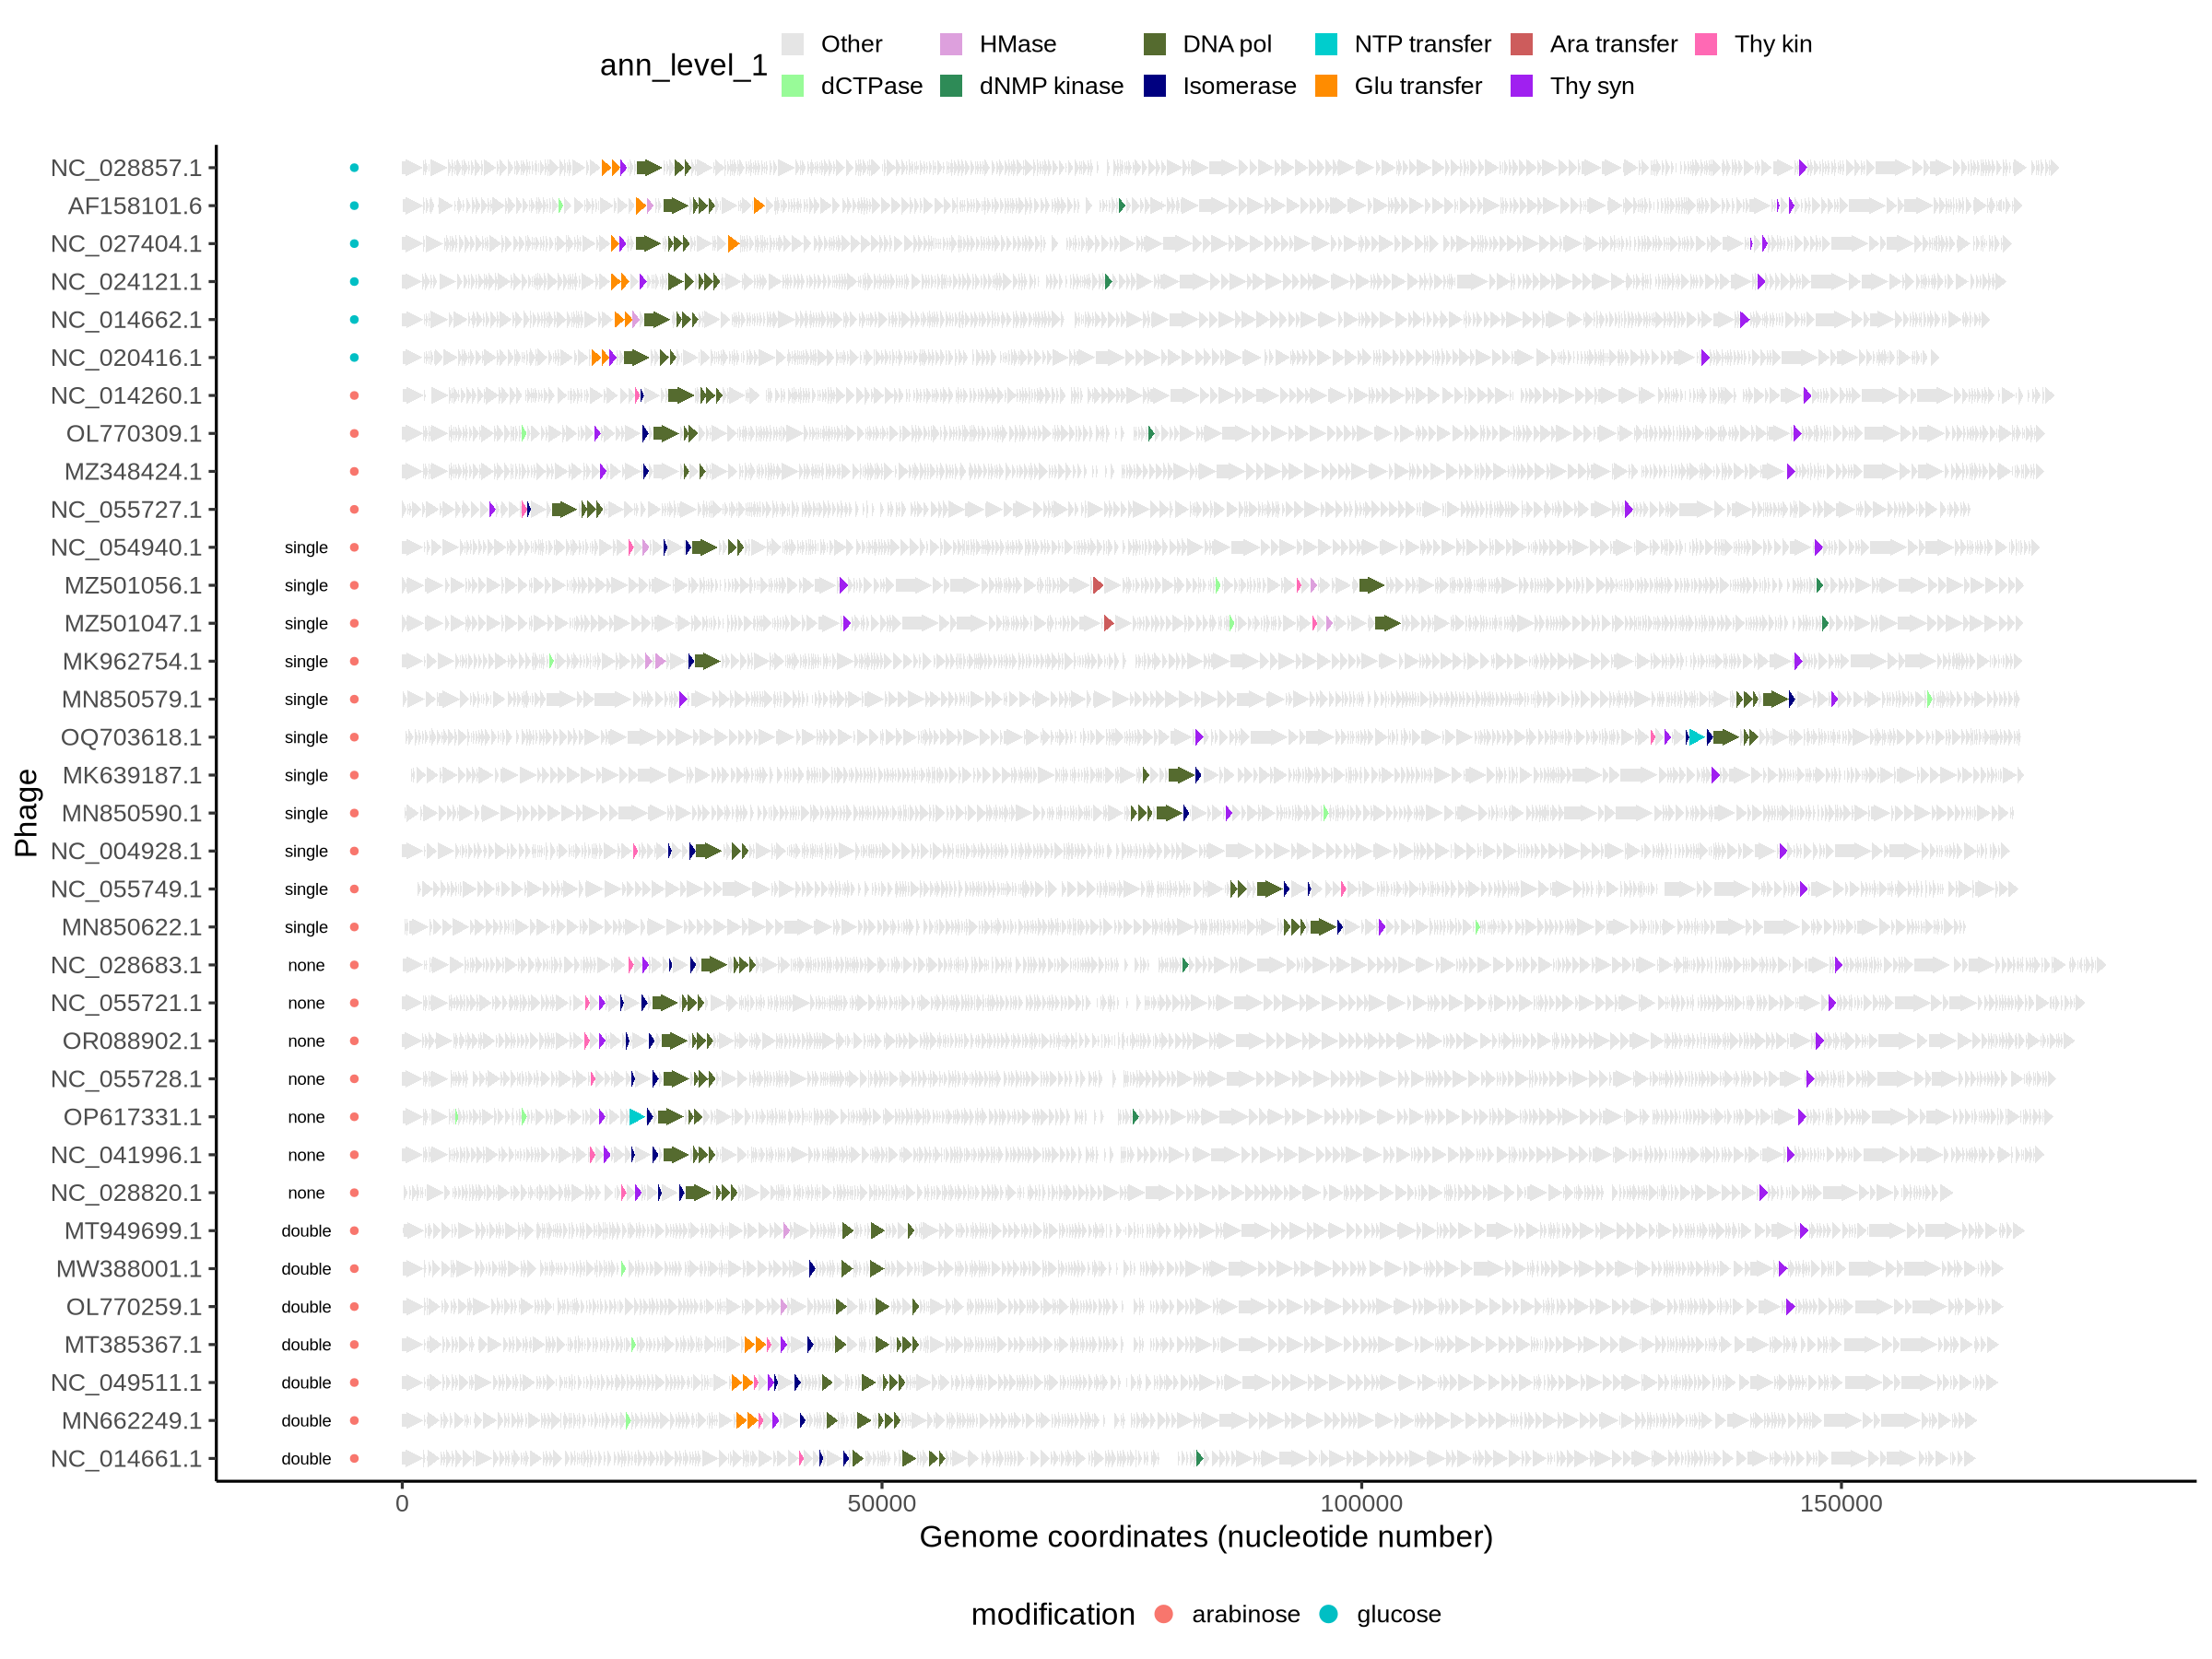

In [101]:
# Visualize genomes
options(repr.plot.width=20, repr.plot.height=15)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat) %>% unique()

## Order
df <- df[order(df$modification, df$aat, df$genomeSize), ]
df$Accession <- factor(df$Accession, unique(df$Accession))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Accession, fill = ann_level_1), col=NA
                   ) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(data=ann, aes(x=-5000, y=Accession, col=modification), size=2) +
    geom_text(data=ann, aes(x=-10000, y=Accession, label=aat)) +
    theme_classic(20) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage")

In [101]:
# Geographic location
unique(report$Geographic.Location)

[1] ""                                                                                                             
   [2] "USA"                                                                                                          
   [3] "China: Korla"                                                                                                 
   [4] "China"                                                                                                        
   [5] "USA: Edinburg, VA"                                                                                            
   [6] "USA: Harrisonburg, VA"                                                                                        
   [7] "India"                                                                                                        
   [8] "Germany: Berlin"                                                                                              
   [9] "Spain"                                                                                                        
  [10] "Germany"                                                                                                      
  [11] "China: Inner Mongolia Hohhot"                                                                                 
  [12] "USA: North Carolina"                                                                                          
  [13] "Kenya"                                                                                                        
  [14] "Japan"                                                                                                        
  [15] "India: Visakhapatnam"                                                                                         
  [16] "Iran"                                                                                                         
  [17] "USA: South Carolina"                                                                                          
  [18] "Malaysia"                                                                                                     
  [19] "Viet Nam"                                                                                                     
  [20] "USA: Poolesville, MD"                                                                                         
  [21] "USA: Tennessee"                                                                                               
  [22] "Slovakia"                                                                                                     
  [23] "Taiwan"                                                                                                       
  [24] "Ireland: Cork"                                                                                                
  [25] "Turkey"                                                                                                       
  [26] "Thailand"                                                                                                     
  [27] "South Korea"                                                                                                  
  [28] "Egypt"                                                                                                        
  [29] "USA: Clear Creek, League City, TX"                                                                            
  [30] "Italy"                                                                                                        
  [31] "India: Ludhiana (Punjab)"                                                                                     
  [32] "Mexico"                                                                                                       
  [33] "USA: Rindge, NH"                                                                                              
  [34] "Sweden"                                                             

In [20]:
## Investigate data report

# Read data report
report <- as.list(readLines(ncbi$data_report, skipNul = TRUE))
report <- lapply(report, fromJSON)

# Re-format
for (n in 1:length(report)) {
    x <- report[[n]]
    report[[n]] <- data.frame(
    accession = get_list_entry(x[["accession"]]),
    virusName = get_list_entry(x[["virus"]][["organismName"]]),
    virusClass = get_list_entry(x[["virus"]][["lineage"]][["name"]][[5]]),
    virusGenus = get_list_entry(x[["virus"]][["lineage"]][["name"]][[6]]),
    completeness = get_list_entry(x[["completeness"]]),
    geneCount = get_list_entry(x[["geneCount"]]),
    genomeSize = get_list_entry(x[["length"]]),
    geoLocation = get_list_entry(x[["location"]][["geographicLocation"]]),
    geoRegion = get_list_entry(x[["location"]][["geographicRegion"]]),
    labHost = get_list_entry(x[["labHost"]])
    )
}
report <- bind_rows(report)

# Check accession numbers
all(data$accession %in% report$accession)
all(report$accession %in% data$accession)

[1] FALSE

[1] FALSE

In [25]:
## Add additional information

# Read genomes
genome <- readDNAStringSet(ncbi$genomic)
names(genome) <- str_split(names(genome), ',',simplify=TRUE)[,1]

# Mutate report
report$key <- paste(report$accession, report$virusName)
report$genomePresent <- names(genome) %in% report$key
report$genomeIndex <- match(names(genome), report$key)

In [26]:
## Investigate report
x <- data$accession %in% report$accession
table(x)
data$accession[!x]

x
FALSE  TRUE 
    3    31 

[1] "NC_028683.1" "NC_055721.1" "NC_055727.1"

In [29]:
## Investigate report

# Dimensions
x <- table(report$genomePresent)
message(paste0("Genomes present \n", "True: ", x[[2]], ", False: ", x[[1]]))
message(paste(ncol(report), "Annotations"))

# View
rbind(head(report,3), tail(report,3))

# Check absence of NAs in important columns
message(paste("Any missing accession:", any(is.na(report$accession))))
message(paste("Any missing virusName:", any(is.na(report$virusName))))

Genomes present 
True: 20940, False: 4859

13 Annotations



,accession,virusName,virusClass,virusGenus,completeness,geneCount,genomeSize,geoLocation,geoRegion,labHost,key,genomePresent,genomeIndex
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<lgl>,<int>
1,OP073944.1,Bacteriophage sp.,NA,NA,COMPLETE,21,22014,Japan,Asia,NA,OP073944.1 Bacteriophage sp.,TRUE,4501
2,OP073957.1,Bacteriophage sp.,NA,NA,COMPLETE,15,17138,Japan,Asia,NA,OP073957.1 Bacteriophage sp.,TRUE,4502
3,OP073961.1,Bacteriophage sp.,NA,NA,COMPLETE,32,31550,Japan,Asia,NA,OP073961.1 Bacteriophage sp.,TRUE,4503
25797,EU855793.1,Listeria phage P40,Caudoviricetes,unclassified Caudoviricetes,COMPLETE,62,35638,Switzerland,Europe,NA,EU855793.1 Listeria phage P40,FALSE,NA
25798,EU861004.1,Staphylococcus phage vB_SauS-phiIPLA88,Caudoviricetes,Azeredovirinae,COMPLETE,61,42526,NA,NA,NA,EU861004.1 Staphylococcus phage vB_SauS-phiIPLA88,FALSE,NA
25799,EU861005.1,Staphylococcus phage phiSauS-IPLA35,Caudoviricetes,Triavirus,COMPLETE,62,45344,NA,NA,NA,EU861005.1 Staphylococcus phage phiSauS-IPLA35,FALSE,NA


Any missing accession: FALSE

Any missing virusName: FALSE



In [30]:
## Save report
write.table(report, genomes$overview, sep = ",")

In [32]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.2 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Pacific/Auckland
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Biostrings_2.70.1   GenomeInfoDb_1.38.1 XVector_0.42.0     
 [4] IRanges_2.36.0      S4Vectors_0.40.2    BiocGenerics_0.48.1
 [7] jsonlite_1.8.9      tidyr_1.3.1         